# Sorption enthalpy calculations

Sorption enthalpy, $\Delta H_{ads}$, is an indication of the strength of the adsorbate-material
interaction and can be estimated through several methods.

## Isosteric enthalpy (Clausius-Clapeyron)

In order to calculate $\Delta H_{ads}$, at least two isotherms which were
taken at different temperatures are required.

First, make sure the data is imported.

In [1]:
# import isotherms
%run import.ipynb
%matplotlib inline

# import the characterisation module
import pygaps.characterisation as pgc

Selected 5 isotherms with nitrogen at 77K
Selected 2 room temperature calorimetry isotherms
Selected 2 isotherms for IAST calculation
Selected 3 isotherms for isosteric enthalpy calculation
The file version is None while the parser uses version 1.0. Strange things might happen, so double check your data.
Could not parse parameter material_mass, currently unknown


Let's quickly plot the isotherms to see how they look. We put the temperature of
the experiment in the legend by using the `lgd_keys` keyword.

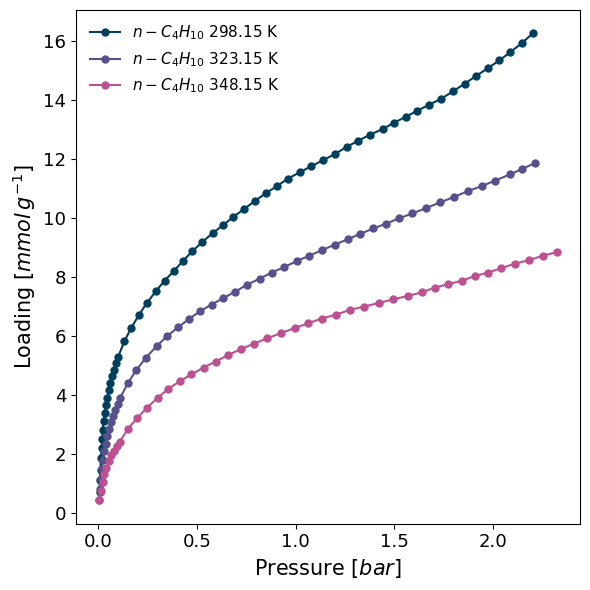

In [2]:
# import the graphing module
import pygaps.graphing as pgg

pgg.plot_iso(
    isotherms_isosteric,
    lgd_keys=['adsorbate', 'temperature'],
)

The isotherms look good, except perhaps a bit of measurement error in the low pressure region.

The isosteric enthalpy calculation takes the list of the isotherms and returns
the results as a dictionary. Using the `verbose` keyword, we also generate a
graph that includes an error bar.

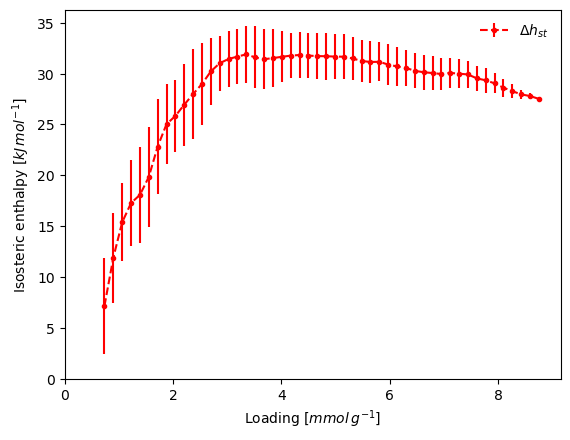

In [3]:
result_dict = pgc.isosteric_enthalpy(isotherms_isosteric, verbose=True)

The inaccuracy in the low pressure region has contributed to the odd enthalpy
curve. One other option would be to first fit a model to each isotherm, then
use it for the enthalpy determination.

Let's try a Double Site Langmuir model and then re-run the isosteric
calculation.

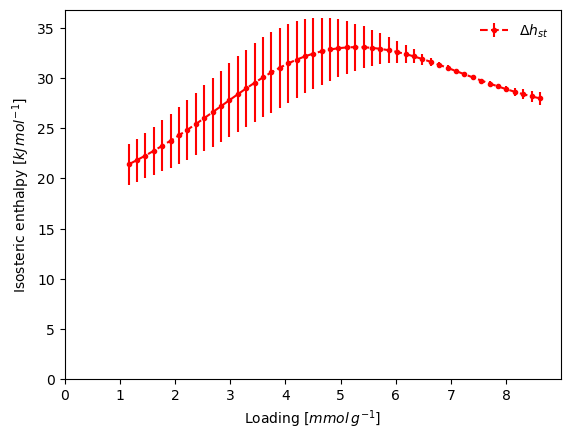

In [4]:
from pygaps.modelling import model_iso
models_isosteric = [
    model_iso(iso, model="dslangmuir")
    for iso in isotherms_isosteric
]
result_dict = pgc.isosteric_enthalpy(models_isosteric, verbose=True)

More information about the functions and their use can be found in the [manual](../manual/characterisation.rst).

## Whittaker method



The Whittaker method uses a Tóth’s modification of Polanyi's potential theory to determine enthalpy of adsorption from a single isotherm fitted with a suitable model.
We loaded the example isotherm before, so we can now plot it.

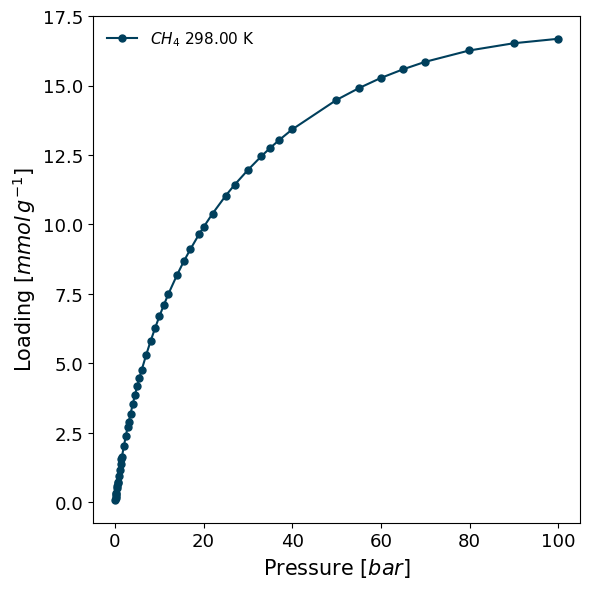

In [5]:
pgg.plot_iso(
    isotherms_enth_whittaker,
    lgd_keys=['adsorbate', 'temperature'],
    pressure_unit='bar'
)

The code can accept a ModelIsotherm of the required type. Note that this isotherm must be in correct pressure mode (`absolute`) and units: (`Pa`).

Thermodynamic backend failed with error: Temperature to QT_flash [298 K] must be in range [90.5941 K, 190.564 K]. Attempting to read parameters dictionary...
methane does not have a saturation pressure at 298.0 K. Calculating pseudo-saturation pressure...


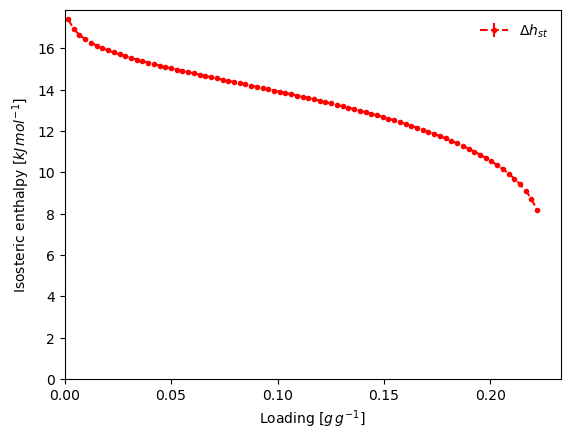

In [6]:
from pygaps.modelling import model_iso
for iso in isotherms_enth_whittaker:
    iso.convert_pressure(mode_to="absolute", unit_to="Pa")
models_whittaker = model_iso(isotherms_enth_whittaker[0], model="Toth")
result_dict = pgc.enthalpy_sorption_whittaker(models_whittaker, verbose=True)

Alternatively, the PointIsotherm and the desired model can be passed as parameters, and fitting is performed automatically before the method is applied.

Attempting to model using Toth.
Model Toth success, RMSE is 0.00493
Thermodynamic backend failed with error: Temperature to QT_flash [298 K] must be in range [90.5941 K, 190.564 K]. Attempting to read parameters dictionary...
methane does not have a saturation pressure at 298.0 K. Calculating pseudo-saturation pressure...


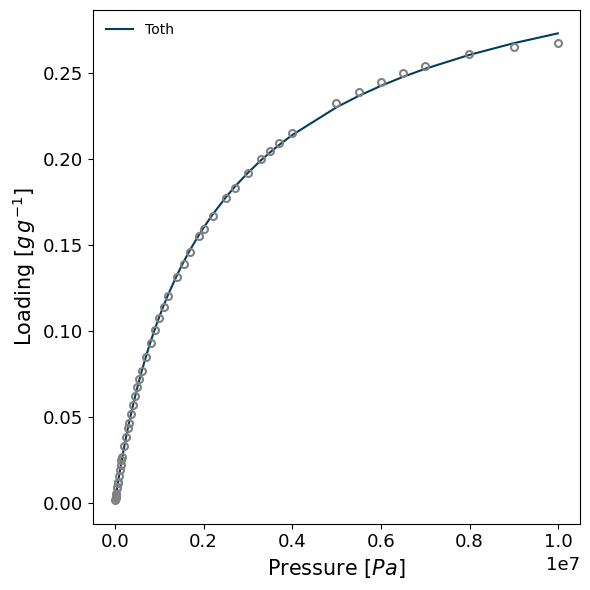

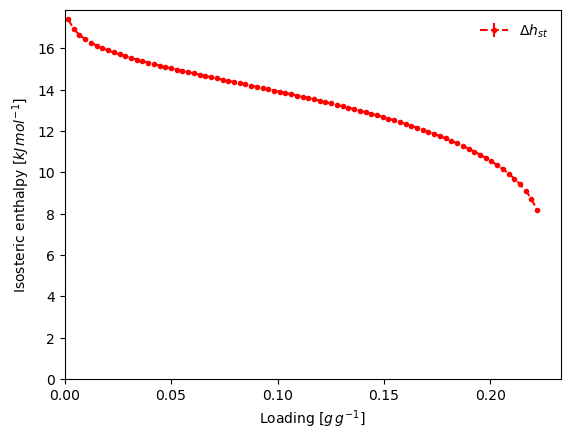

In [7]:
result_dict = pgc.enthalpy_sorption_whittaker(isotherms_enth_whittaker[0], model="Toth", verbose=True)